<a href="https://colab.research.google.com/github/choki0715/lecture/blob/master/Unet.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Introduction

The U-Net model is a simple fully  convolutional neural network that is used for binary segmentation i.e foreground and background pixel-wise classification. Mainly, it consists of two parts. 

*   Contracting Path: we apply a series of conv layers and downsampling layers  (max-pooling) layers to reduce the spatial size 
*   Expanding Path: we apply a series of upsampling layers to reconstruct the spatial size of the input. 

The two parts are connected using a concatenation layers among different levels. This allows learning different features at different levels. At the end we have a simple conv 1x1 layer to reduce the number of channels to 1. 


![alt text](https://blog.playment.io/wp-content/uploads/2018/03/Screen-Shot-2018-09-05-at-3.00.03-PM.png)

# Imports

In [19]:
import numpy as np
import matplotlib.pyplot as plt
import os
import tensorflow as tf
from PIL import Image
from tensorflow.keras import Model
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Input, Conv2DTranspose, Concatenate, BatchNormalization, UpSampling2D
from tensorflow.keras.layers import  Dropout, Activation
from tensorflow.keras.optimizers import Adam, SGD
from tensorflow.keras.activations import relu
from tensorflow.keras.callbacks import ModelCheckpoint, ReduceLROnPlateau, EarlyStopping
from tensorflow.keras import backend as K
from tensorflow.keras.utils import plot_model

import glob
import random
import cv2
from random import shuffle

# Dataset

We will use the The Oxford-IIIT Pet Dataset. It contains 37 classes of dogs and cats with around 200 images per each class. The dataset contains labels as bounding boxes and segmentation masks. The total number of images in the dataset is a little more than 7K. 

![alt text](http://www.robots.ox.ac.uk/~vgg/data/pets/pet_annotations.jpg)

Download the images/masks and unzip the files 

In [7]:
!wget http://www.robots.ox.ac.uk/~vgg/data/pets/data/images.tar.gz
!wget http://www.robots.ox.ac.uk/~vgg/data/pets/data/annotations.tar.gz
!tar -xvzf images.tar.gz && tar -xvzf annotations.tar.gz
!rm  images/*.mat

스트리밍 출력 내용이 길어서 마지막 5000줄이 삭제되었습니다.
annotations/trimaps/._pomeranian_180.png
annotations/trimaps/pomeranian_180.png
annotations/trimaps/._pomeranian_181.png
annotations/trimaps/pomeranian_181.png
annotations/trimaps/._pomeranian_182.png
annotations/trimaps/pomeranian_182.png
annotations/trimaps/._pomeranian_183.png
annotations/trimaps/pomeranian_183.png
annotations/trimaps/._pomeranian_184.png
annotations/trimaps/pomeranian_184.png
annotations/trimaps/._pomeranian_185.png
annotations/trimaps/pomeranian_185.png
annotations/trimaps/._pomeranian_186.png
annotations/trimaps/pomeranian_186.png
annotations/trimaps/._pomeranian_187.png
annotations/trimaps/pomeranian_187.png
annotations/trimaps/._pomeranian_188.png
annotations/trimaps/pomeranian_188.png
annotations/trimaps/._pomeranian_189.png
annotations/trimaps/pomeranian_189.png
annotations/trimaps/._pomeranian_19.png
annotations/trimaps/pomeranian_19.png
annotations/trimaps/._pomeranian_190.png
annotations/trimaps/pomeranian_190.png
annota

Note that we have two foulders. The first one is `images` which contains the raw images and annotation which contains the masks as a `binary` foulder image.

# Generators

In [20]:
def image_generator(files, batch_size = 32, sz = (256, 256)):
  
  while True: 
    
    #extract a random batch 
    batch = np.random.choice(files, size = batch_size)    
    
    #variables for collecting batches of inputs and outputs 
    batch_x = []
    batch_y = []
    
    
    for f in batch:

        #get the masks. Note that masks are png files 
        mask = Image.open(f'annotations/trimaps/{f[:-4]}.png')
        mask = np.array(mask.resize(sz))


        #preprocess the mask 
        mask[mask >= 2] = 0 
        mask[mask != 0 ] = 1
        
        batch_y.append(mask)

        #preprocess the raw images 
        raw = Image.open(f'images/{f}')
        raw = raw.resize(sz)
        raw = np.array(raw)

        #check the number of channels because some of the images are RGBA or GRAY
        if len(raw.shape) == 2:
          raw = np.stack((raw,)*3, axis=-1)

        else:
          raw = raw[:,:,0:3]

        batch_x.append(raw)

    #preprocess a batch of images and masks 
    batch_x = np.array(batch_x)/255.
    batch_y = np.array(batch_y)
    batch_y = np.expand_dims(batch_y,3)

    yield (batch_x, batch_y)      
    

In [21]:
batch_size = 32

all_files = os.listdir('images')
shuffle(all_files)

split = int(0.95 * len(all_files))

#split into training and testing
train_files = all_files[0:split]
test_files  = all_files[split:]

train_generator = image_generator(train_files, batch_size = batch_size)
test_generator  = image_generator(test_files, batch_size = batch_size)

In [22]:
x, y= next(train_generator)

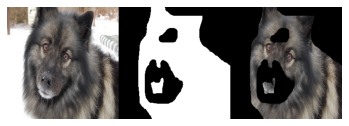

In [23]:
plt.axis('off')
img = x[0]
msk = y[0].squeeze()
msk = np.stack((msk,)*3, axis=-1)

plt.imshow( np.concatenate([img, msk, img*msk], axis = 1))

# IoU metric

The intersection over union (IoU) metric is a simple metric used to evaluate the performance of a segmentation algorithm. Given two masks $y_{true}, y_{pred}$ we evaluate 

$$IoU = \frac{y_{true} \cap y_{pred}}{y_{true} \cup y_{pred}}$$

In [29]:
def mean_iou(y_true, y_pred):
    yt0 = y_true[:,:,:,0]
    yp0 = K.cast(y_pred[:,:,:,0] > 0.5, 'float32')
    inter = tf.math.count_nonzero(tf.logical_and(tf.equal(yt0, 1), tf.equal(yp0, 1)))
    union = tf.math.count_nonzero(tf.add(yt0, yp0))
    iou = tf.where(tf.equal(union, 0), 1., tf.cast(inter/union, 'float32'))
    return iou

# Model

In [30]:
def unet(sz = (256, 256, 3)):
  x = Input(sz)
  inputs = x
  
  #down sampling 
  f = 8
  layers = []
  
  for i in range(0, 6):
    x = Conv2D(f, 3, activation='relu', padding='same') (x)
    x = Conv2D(f, 3, activation='relu', padding='same') (x)
    layers.append(x)
    x = MaxPooling2D() (x)
    f = f*2
  ff2 = 64 
  
  #bottleneck 
  j = len(layers) - 1
  x = Conv2D(f, 3, activation='relu', padding='same') (x)
  x = Conv2D(f, 3, activation='relu', padding='same') (x)
  x = Conv2DTranspose(ff2, 2, strides=(2, 2), padding='same') (x)
  x = Concatenate(axis=3)([x, layers[j]])
  j = j -1 
  
  #upsampling 
  for i in range(0, 5):
    ff2 = ff2//2
    f = f // 2 
    x = Conv2D(f, 3, activation='relu', padding='same') (x)
    x = Conv2D(f, 3, activation='relu', padding='same') (x)
    x = Conv2DTranspose(ff2, 2, strides=(2, 2), padding='same') (x)
    x = Concatenate(axis=3)([x, layers[j]])
    j = j -1 
    
  
  #classification 
  x = Conv2D(f, 3, activation='relu', padding='same') (x)
  x = Conv2D(f, 3, activation='relu', padding='same') (x)
  outputs = Conv2D(1, 1, activation='sigmoid') (x)
  
  #model creation 
  model = Model(inputs=[inputs], outputs=[outputs])
  model.compile(optimizer = 'rmsprop', loss = 'binary_crossentropy', metrics = [mean_iou])
  
  return model

In [31]:
model = unet()

# Callbacks

Simple functions to save the model at each epoch and show some predictions 

In [32]:
def build_callbacks():
        checkpointer = ModelCheckpoint(filepath='unet.h5', verbose=0, save_best_only=True, save_weights_only=True)
        callbacks = [checkpointer, PlotLearning()]
        return callbacks

# inheritance for training process plot 
class PlotLearning(tf.keras.callbacks.Callback):

    def on_train_begin(self, logs={}):
        self.i = 0
        self.x = []
        self.losses = []
        self.val_losses = []
        self.acc = []
        self.val_acc = []
        #self.fig = plt.figure()
        self.logs = []
    def on_epoch_end(self, epoch, logs={}):
        self.logs.append(logs)
        self.x.append(self.i)
        self.losses.append(logs.get('loss'))
        self.val_losses.append(logs.get('val_loss'))
        self.acc.append(logs.get('mean_iou'))
        self.val_acc.append(logs.get('val_mean_iou'))
        self.i += 1
        print('i=',self.i,'loss=',logs.get('loss'),'val_loss=',logs.get('val_loss'),'mean_iou=',logs.get('mean_iou'),'val_mean_iou=',logs.get('val_mean_iou'))
        
        #choose a random test image and preprocess
        path = np.random.choice(test_files)
        raw = Image.open(f'images/{path}')
        raw = np.array(raw.resize((256, 256)))/255.
        raw = raw[:,:,0:3]
        
        #predict the mask 
        pred = model.predict(np.expand_dims(raw, 0))
        
        #mask post-processing 
        msk  = pred.squeeze()
        msk = np.stack((msk,)*3, axis=-1)
        msk[msk >= 0.5] = 1 
        msk[msk < 0.5] = 0 
        
        #show the mask and the segmented image 
        combined = np.concatenate([raw, msk, raw* msk], axis = 1)
        plt.axis('off')
        plt.imshow(combined)
        plt.show()

# Training

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:5: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  """


i= 1 loss= 0.5177964568138123 val_loss= 0.44838276505470276 mean_iou= 0.23031821846961975 val_mean_iou= 0.4267597198486328


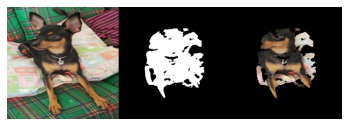

i= 2 loss= 0.442066490650177 val_loss= 0.4092729389667511 mean_iou= 0.4539503753185272 val_mean_iou= 0.4950658977031708


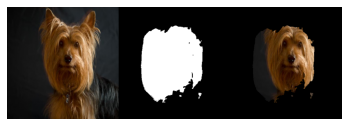

i= 3 loss= 0.4141152799129486 val_loss= 0.42707738280296326 mean_iou= 0.4791746139526367 val_mean_iou= 0.5096244812011719


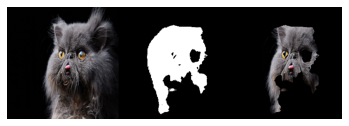

i= 4 loss= 0.3733167350292206 val_loss= 0.35282400250434875 mean_iou= 0.543604850769043 val_mean_iou= 0.5024075508117676


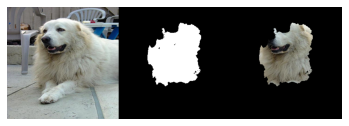

i= 5 loss= 0.3328554928302765 val_loss= 0.32871952652931213 mean_iou= 0.5975369215011597 val_mean_iou= 0.5769580006599426


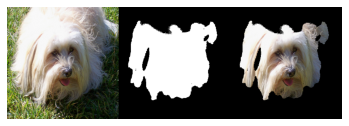

i= 6 loss= 0.2981468737125397 val_loss= 0.27679693698883057 mean_iou= 0.6390678286552429 val_mean_iou= 0.6701327562332153


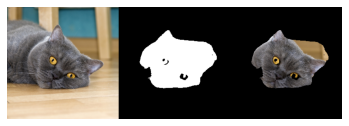

i= 7 loss= 0.2693532705307007 val_loss= 0.2810544967651367 mean_iou= 0.6770042777061462 val_mean_iou= 0.6839389801025391


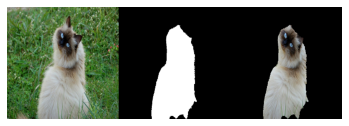

i= 8 loss= 0.25404614210128784 val_loss= 0.2407309114933014 mean_iou= 0.6985064148902893 val_mean_iou= 0.7328510284423828


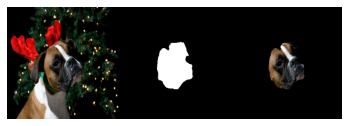

i= 9 loss= 0.22991345822811127 val_loss= 0.2387896478176117 mean_iou= 0.726004421710968 val_mean_iou= 0.7258502840995789


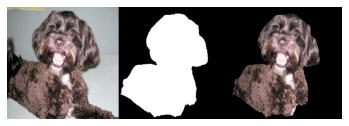

i= 10 loss= 0.22022533416748047 val_loss= 0.21216648817062378 mean_iou= 0.7401354908943176 val_mean_iou= 0.7540313601493835


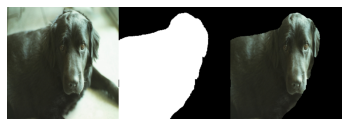

i= 11 loss= 0.20804175734519958 val_loss= 0.23567265272140503 mean_iou= 0.7541154026985168 val_mean_iou= 0.7176888585090637


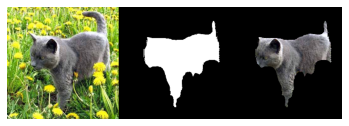

i= 12 loss= 0.1894693821668625 val_loss= 0.25374090671539307 mean_iou= 0.7725521326065063 val_mean_iou= 0.7336257696151733


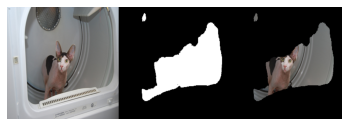

i= 13 loss= 0.1850670874118805 val_loss= 0.20949238538742065 mean_iou= 0.7776956558227539 val_mean_iou= 0.753352701663971


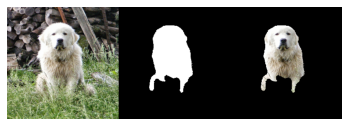

i= 14 loss= 0.170161172747612 val_loss= 0.2602018415927887 mean_iou= 0.7943516969680786 val_mean_iou= 0.6813709139823914


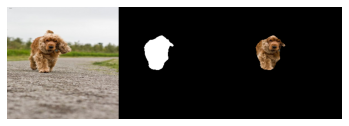

i= 15 loss= 0.16379019618034363 val_loss= 0.2119722217321396 mean_iou= 0.8017352819442749 val_mean_iou= 0.7475131750106812


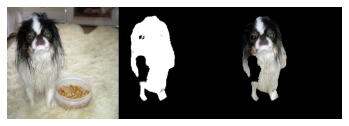

i= 16 loss= 0.15240523219108582 val_loss= 0.22405466437339783 mean_iou= 0.8117608428001404 val_mean_iou= 0.7540439963340759


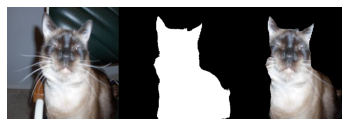

i= 17 loss= 0.14721420407295227 val_loss= 0.22053566575050354 mean_iou= 0.8185904622077942 val_mean_iou= 0.7548091411590576


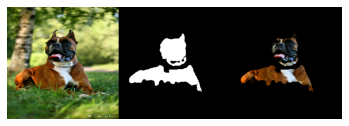

i= 18 loss= 0.13663698732852936 val_loss= 0.23145844042301178 mean_iou= 0.8314983248710632 val_mean_iou= 0.7444204092025757


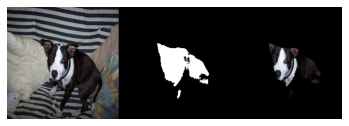

i= 19 loss= 0.1314767748117447 val_loss= 0.23769259452819824 mean_iou= 0.8363219499588013 val_mean_iou= 0.7413498163223267


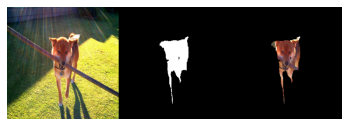

i= 20 loss= 0.12783750891685486 val_loss= 0.19795571267604828 mean_iou= 0.841383695602417 val_mean_iou= 0.7654663324356079


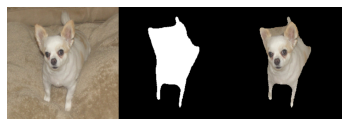

i= 21 loss= 0.1201331838965416 val_loss= 0.22959986329078674 mean_iou= 0.84849613904953 val_mean_iou= 0.7719097137451172


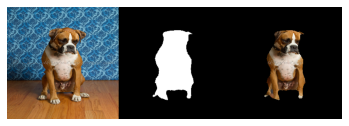

i= 22 loss= 0.11668968945741653 val_loss= 0.2757386267185211 mean_iou= 0.8531181812286377 val_mean_iou= 0.7611663341522217


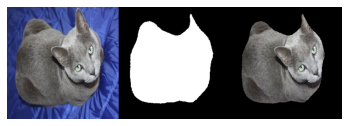

i= 23 loss= 0.1123540848493576 val_loss= 0.27147629857063293 mean_iou= 0.8584154844284058 val_mean_iou= 0.765923261642456


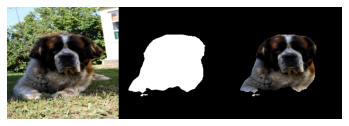

i= 24 loss= 0.10555090755224228 val_loss= 0.27232620120048523 mean_iou= 0.8645406365394592 val_mean_iou= 0.7865096926689148


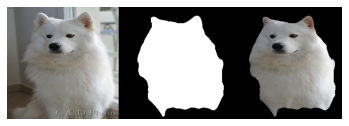

i= 25 loss= 0.10544242709875107 val_loss= 0.19114655256271362 mean_iou= 0.866226315498352 val_mean_iou= 0.7681293487548828


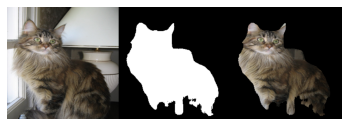

i= 26 loss= 0.10086511820554733 val_loss= 0.2943515479564667 mean_iou= 0.870289146900177 val_mean_iou= 0.7228267192840576


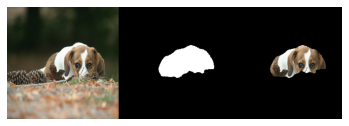

i= 27 loss= 0.09803278744220734 val_loss= 0.24425174295902252 mean_iou= 0.8753952383995056 val_mean_iou= 0.7635685205459595


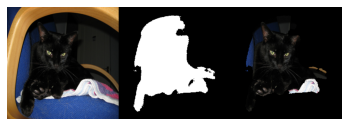

i= 28 loss= 0.09527958929538727 val_loss= 0.2931002378463745 mean_iou= 0.8768522143363953 val_mean_iou= 0.768010139465332


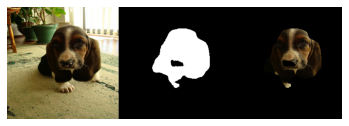

i= 29 loss= 0.09178750962018967 val_loss= 0.29327210783958435 mean_iou= 0.8808214664459229 val_mean_iou= 0.7553887963294983


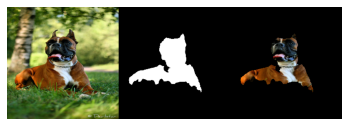

i= 30 loss= 0.09284748136997223 val_loss= 0.23669172823429108 mean_iou= 0.881110668182373 val_mean_iou= 0.7710437774658203


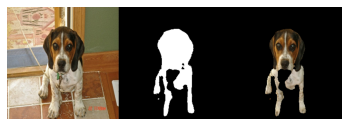

In [33]:
train_steps = len(train_files) //batch_size
test_steps = len(test_files) //batch_size
model.fit_generator(train_generator, 
                    epochs = 30, steps_per_epoch = train_steps,validation_data = test_generator, validation_steps = test_steps,
                    callbacks = build_callbacks(), verbose = 0)

# Testing

In [34]:
!wget http://r.ddmcdn.com/s_f/o_1/cx_462/cy_245/cw_1349/ch_1349/w_720/APL/uploads/2015/06/caturday-shutterstock_149320799.jpg -O test.jpg

--2022-03-27 11:21:40--  http://r.ddmcdn.com/s_f/o_1/cx_462/cy_245/cw_1349/ch_1349/w_720/APL/uploads/2015/06/caturday-shutterstock_149320799.jpg
Resolving r.ddmcdn.com (r.ddmcdn.com)... 13.226.122.121, 13.226.122.55, 13.226.122.111, ...
Connecting to r.ddmcdn.com (r.ddmcdn.com)|13.226.122.121|:80... connected.
HTTP request sent, awaiting response... 200 OK
Length: 63219 (62K) [image/jpeg]
Saving to: ‘test.jpg’

test.jpg            100%[===================>]  61.74K   132KB/s    in 0.5s    

2022-03-27 11:21:41 (132 KB/s) - ‘test.jpg’ saved [63219/63219]



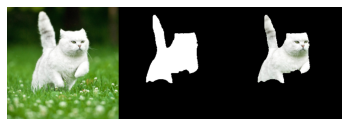

In [35]:
raw = Image.open('test.jpg')
raw = np.array(raw.resize((256, 256)))/255.
raw = raw[:,:,0:3]

#predict the mask 
pred = model.predict(np.expand_dims(raw, 0))

#mask post-processing 
msk  = pred.squeeze()
msk = np.stack((msk,)*3, axis=-1)
msk[msk >= 0.5] = 1 
msk[msk < 0.5] = 0 

#show the mask and the segmented image 
combined = np.concatenate([raw, msk, raw* msk], axis = 1)
plt.axis('off')
plt.imshow(combined)
plt.show()

# References


1.   http://deeplearning.net/tutorial/unet.html
2.   https://github.com/ldenoue/keras-unet

